# Drugs From One-Step Amide Formation

## Load modules

In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw 
from rdkit import rdBase
from rdkit.Chem import PandasTools
import pandas as pd
import csv

print('RDKit version: %s' % rdBase.rdkitVersion)

RDKit version: 2019.03.4


# Read reagents SMILES file (and hash) into dictionary

The resulting fragments from retrosynthesis will be removed if they exist in the dictionary

In [15]:
reagentsFile = 'data/sampleReagents.smi'

reagents = Chem.rdmolfiles.SmilesMolSupplier(reagentsFile, titleLine=False)
inchiKeyDict = {Chem.MolToInchiKey(reagent): reagent.GetProp("_Name") for reagent in reagents}
smiDict = {reagent.GetProp("_Name"): Chem.MolToSmiles(reagent) for reagent in reagents}
print("Number of reagents:", len(reagents))

Number of reagents: 12


## Read reagents SMILES file (and hash) into data frame

,MolName,SMILES,inchiKey,Molecule
10,MFCD00008205,CCCN,WGYKZJWCGVVSQN-UHFFFAOYSA-N,
11,MFCD00454650,CCOC(=O)NS(=O)(=O)c1ccc(Cl)cc1,FACGRORYCNHVPV-UHFFFAOYSA-N,

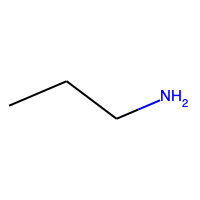
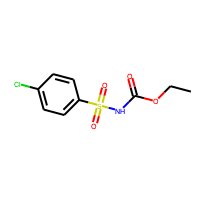

In [16]:
def extractReagentData(reagent):
    return (reagent.GetProp("_Name"), Chem.MolToSmiles(reagent), Chem.MolToInchiKey(reagent))

data = (extractReagentData(reagent) for reagent in reagents)
df = pd.DataFrame(data, columns=['MolName', 'SMILES', 'inchiKey'])

PandasTools.AddMoleculeColumnToFrame(df, 'SMILES','Molecule', includeFingerprints=False)
df.tail(2)

## Read SDF file with drugs into list of drugs

In [17]:
drugsFileNameSDF = 'data/sampleDrugs.sdf'
supplier = Chem.SDMolSupplier(drugsFileNameSDF)

drugsList = [x for x in supplier if x is not None]
print("Number of drugs:", len(drugsList))

Number of drugs: 6




# Define a couple of amide reactions

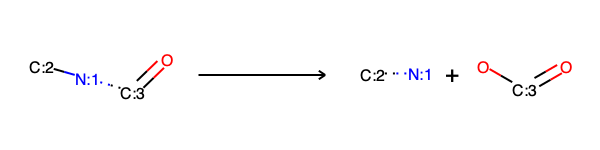

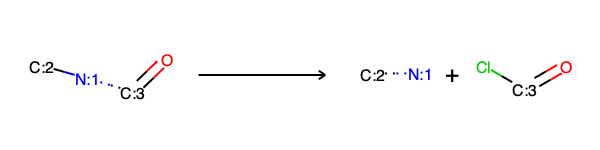

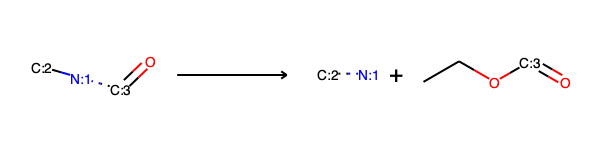

In [18]:
amideSmarts = "[CX3:3](=[OX1])!@[NX3:1]-[#6:2]"
amineSmarts = "[#6:2][NX3:1]"

acidRxn = AllChem.ReactionFromSmarts(
    f'{amideSmarts}>>\
    {amineSmarts}.[CX3:3](=[OX1])-[OH]'
)
acidChlorideRxn = AllChem.ReactionFromSmarts(
    f'{amideSmarts}>>\
    {amineSmarts}.[CX3:3](=[OX1])-[Cl]'
)

ethylEsterRxn = AllChem.ReactionFromSmarts(
    f'{amideSmarts}>>\
    {amineSmarts}.[CX3:3](=[OX1])-[O]-[CH2]-[CH3]'
)

display(acidRxn)
display(acidChlorideRxn)
display(ethylEsterRxn)

## Check if drug contains amide bond

In [19]:
amideDrugs = [drug for drug in drugsList if drug.HasSubstructMatch(Chem.MolFromSmarts(amideSmarts))]
hitCount = len(amideDrugs)
percentage = 100*(hitCount/len(drugsList))
        
print(f"This many drugs contain a non-cyclic amide: {hitCount} out of {len(drugsList)} ({percentage:.2f} percent)")

This many drugs contain a non-cyclic amide: 6 out of 6 (100.00 percent)


## Reaction functions 

In [20]:
def getReagentID(reagent):
    result = inchiKeyDict.get(Chem.MolToInchiKey(reagent), "")
    return result

def addHsAndCoords(mol):
    mol.UpdatePropertyCache(strict=False)
    Chem.AddHs(mol, addCoords=True)
    AllChem.Compute2DCoords(mol)
    return mol

def runRxns(amide, rxns):
    reactantLists = [
        reaction.RunReactants([amide])
        for reaction in reactions
    ]
    return list(zip(*reactantLists))

def dfRowFromRxn(amide, amineAcidPairs):
    amine = amineAcidPairs[0][0]
    amineID = getReagentID(amine)
    acids = [
        acid # [1] => acid
        for _, acid in amineAcidPairs
    ]
    try:
        for acid in acids:
            acid = addHsAndCoords(acid)
    except:
        return []
    
    acidIDs = [
        getReagentID(acid)
        for acid in acids
    ]
    if amineID and any(acidIDs):
        reagentSection = [
            rowItem 
            for pair in zip(acidIDs, acids)
            for rowItem in (pair if pair[0] else ("", ""))
        ]
        amine = addHsAndCoords(amine)
        return [amide.GetProp("_Name"), amide, amineID, amine] + reagentSection
    else:
        return []

def makeAmideDrugsDataFrame(drugs, reactions):   
    dfRows = [
        dfRowFromRxn(drug, amineAcidPairs)
        for drug in drugs
        for amineAcidPairs in runRxns(drug, reactions)
    ]
    df_drugs = pd.DataFrame(
        filter(None, dfRows),
        columns=["DrugName", "Drug",
                "AmineID", "Amine",
                "AcidID", "Acid",
                "AcidChlorideID", "AcidChloride",
                "EthylEsterID", "EthylEster"]
    )
    return df_drugs

## Break amide bonds according to reactions, check for availability

Starting...


,DrugName,Drug,AmineID,Amine,AcidID,Acid,AcidChlorideID,AcidChloride,EthylEsterID,EthylEster
0,Maraviroc,,MFCD18381982,,,,MFCD13173983,,,
1,Cefazolin,,MFCD29913098,,,,MFCD02094027,,,
2,Sunitinib Malate,,MFCD00008176,,MFCD11521323,,,,,
3,Capecitabine,,MFCD07369278,,,,MFCD00058933,,,
4,Amisulpride,,MFCD00003178,,MFCD04973619,,,,,
5,Chlorpropamide,,MFCD00008205,,,,,,MFCD00454650,

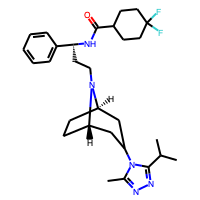
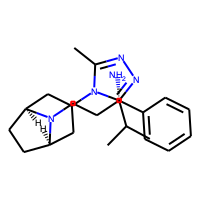
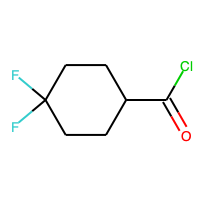
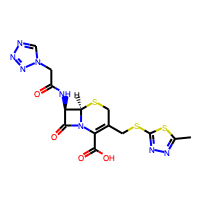
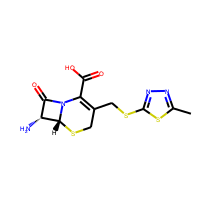
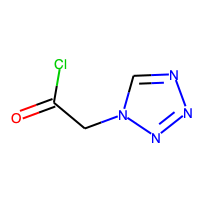
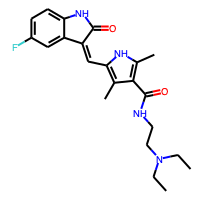
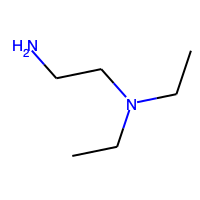
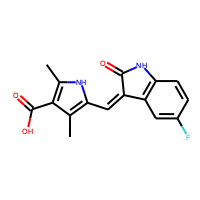
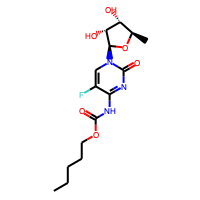
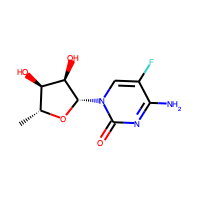
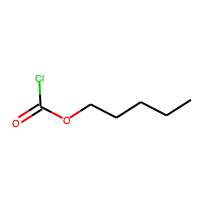
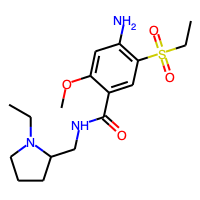
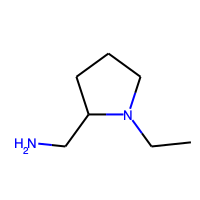
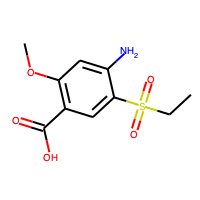
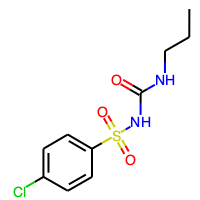
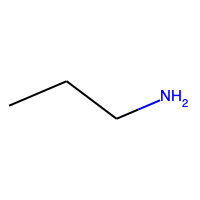
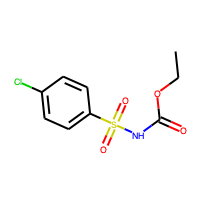

In [21]:
print('Starting...')
reactions = [acidRxn, acidChlorideRxn, ethylEsterRxn]
df_drugs = makeAmideDrugsDataFrame(amideDrugs,reactions)
df_drugs

## Dump identifiers to csv file (for purchase)

In [22]:
columns = ['DrugName','AmineID','AcidID','AcidChlorideID','EthylEsterID']
dumpcsv = df_drugs[columns].to_csv('data/amideDrugsNreagents.csv', index=False)

## Results in csv file, one per line and SMILES added

In [23]:
out = open('data/amideDrugsNreagentsSMILES.csv', 'w')
out.write("DrugID,AmineID,Amine_smi,OtherID,Other_smi\n")

with open('amideDrugsNreagents.csv', "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for lines in csv_reader:
        drugID = lines[0]
        amineID = lines[1]
        amine_smi = smiDict[amineID]
        acidIDs = lines[2:]
        acidIDs = [i for i in acidIDs if i]    
        for acidID in acidIDs:
            acid_smi = smiDict[acidID]
            out.write("%s,%s,%s,%s,%s\n" % (drugID,amineID,amine_smi,acidID,acid_smi))
out.close()